# Objective : 

NBA has the highest home-court win percentage of the four major American sports leagues, with a historical overall winning percentage of 60%. 

We want to investigate the reason behind this statistic. 

#### Why analyze stats for the Regular Season and not Post Season/Playoffs?

During the regular season, teams have very little preparation time for a game. They generally arrive at the home teams stadium the night before. So, the effects of scouting and advanced tactics are much less expressed during the regular season. Moreover, teams in the NBA are notorious for not playing their best players/ optimal intensity during the playoffs. So, teams are a bit more balanced and elite teams have a greater chance of losing. This implies that if any such thing as home advantage exists, it will be much more pronounced during the regular season. 


In [17]:
# imports
import pandas as pd
import sklearn
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from scipy import stats
from statsmodels.stats import weightstats as stests
from scipy.stats import ttest_ind
from sklearn.manifold import TSNE
from matplotlib import rcParams
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA 
import pprint

We will be using 3 dataframes for our home advantage analysis:

# 1. master_df 

#### GLOSSARY
contains the following features separated by home and away for all seasons from 2002-2020.

GP:Games Played | GS:Games Started | MIN:Minutes Per Game | PTS:Points Per Game | OR:Offensive Rebounds Per Game

DR:Defensive Rebounds Per Game | REB:Rebounds Per Game | AST:Assists Per Game | STL:Steals Per Game 

BLK:Blocks Per Game | TO:Turnovers Per Game | PF:Fouls Per Game | AST/TO:Assist To Turnover Ratio


# 2. shots_df 

#### GLOSSARY
contains the following features separated by home and away for all seasons from 2002-2020.

FGM:Average Field Goals Made | FGA:Average Field Goals Attempted | FG%:Field Goal Percentage

3PM:Average 3-Point Field Goals Made | 3PA:Average 3-Point Field Goals Attempted | 3P%:3-Point Field Goal Percentage

FTM:Average Free Throws Made | FTA:Average Free Throws Attempted | FT%:Free Throw Percentage 

2PM:2-Point Field Goals Made / game | 2PA:2-Point Field Goals Attempted per Game | 2P%:2-Point Field Goal Percentage

SC-EFF:Scoring Efficiency | SH-EFF:Shooting Efficiency

# 3.ref_df

#### GLOSSARY
contains the following statistics of referees from 2009-2020

YEAR:year of officiating | TYPE:Crew Referee/Main Referee | GAMES OFFICIATED: No. of games officiated in that year

HTW%:Home team win % under that referee | HTPD:Home team points differential | TPPG:Average total points per game

CFPG:Called fouls per game | FAR%:Foul % agaist away teams | FAH%:Foul percentage against home teams

# Load the Datasets

In [2]:
# type = 33 refers to home games, 34 refers to away games
master_df = pd.read_csv('home_away.csv')
master_df.head()

,PNAME,POS,TEAM,YEAR,TYPE,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,PER
0,Jamal Mashburn,SF,no,2003,33,41,40,40.4,22.4,0.7,5.6,6.3,5.7,1.0,0.3,2.9,2.3,2.0,0
1,David Wesley,SG,no,2003,33,36,36,38.1,17.6,0.7,1.8,2.5,4.0,1.6,0.2,1.8,2.5,2.2,0
2,Baron Davis,PG,no,2003,33,25,25,37.0,16.9,1.0,2.7,3.7,7.4,2.0,0.6,2.8,3.0,2.7,0
3,Jamaal Magloire,C,no,2003,33,41,41,31.5,11.5,3.7,6.3,10.0,1.5,0.7,1.6,1.9,3.2,0.8,0
4,P.J. Brown,PF,no,2003,33,39,39,32.9,11.3,2.7,5.7,8.4,1.9,0.9,1.0,1.3,2.6,1.4,0


In [3]:
# type = 33 refers to home games, 34 refers to away games
shots_df = pd.read_csv('shots_home_away_stats.csv')
shots_df.head()

,PNAME,POS,TEAM,YEAR,TYPE,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF
0,Shareef Abdur-Rahim,PF,atl,2002,33,8.1,17.1,47.4,0.4,1.1,39.0,5.2,6.4,81.6,7.7,16.0,48.0,1.279,0.49
1,Jason Terry,G,atl,2002,33,7.3,16.3,44.6,2.3,5.7,39.9,3.9,4.7,82.0,5.0,10.6,47.1,1.269,0.52
2,Theo Ratliff,C,atl,2002,33,5.0,8.0,62.5,0.0,0.0,0.0,2.0,6.0,33.3,5.0,8.0,62.5,1.500,0.63
3,Toni Kukoc,SF,atl,2002,33,4.1,9.1,45.3,1.1,3.0,36.7,2.0,2.7,76.3,3.0,6.1,49.5,1.248,0.51
4,Dion Glover,SG,atl,2002,33,4.5,9.8,46.3,0.8,2.3,36.8,1.3,1.6,78.0,3.7,7.5,49.2,1.143,0.51


In [4]:
ref_df = pd.read_csv('referee_stats.csv')
ref_df.head()

,YEAR,TYPE,GAMES OFFICIATED,HTW%,HTPD,TPPG,CFPG,FAR%,FAH%
0,2020,CREW,54,0.574,3.704,217.370,39.333,50.189,49.812
1,2020,CREW,55,0.618,2.745,221.618,42.545,50.855,49.146
2,2020,CREW,55,0.564,2.036,224.582,43.273,50.126,49.874
3,2020,CREW,56,0.464,0.571,226.393,40.768,51.905,48.094
4,2020,CREW,54,0.500,-0.278,229.870,44.185,50.797,49.204


# Clean the Datasets

In [5]:
master_df.describe()

,YEAR,TYPE,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,PER
count,19289.000000,19289.000000,19289.000000,19289.000000,19289.000000,19289.00000,19289.000000,19289.000000,19289.000000,19289.000000,19289.000000,19289.000000,19289.000000,19289.000000,19289.0,19289.0
mean,2011.495982,33.499093,23.632174,11.450308,20.059443,8.08045,0.918715,2.592742,3.508761,1.786002,0.629307,0.402167,1.151874,1.801659,inf,0.0
std,5.472670,0.500012,13.132732,13.993289,10.014791,5.97299,0.835390,1.821683,2.502688,1.786815,0.464474,0.481532,0.813595,0.849869,NaN,0.0
min,2002.000000,33.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,2007.000000,33.000000,12.000000,0.000000,11.900000,3.50000,0.300000,1.300000,1.700000,0.600000,0.300000,0.100000,0.600000,1.200000,0.8,0.0
50%,2012.000000,33.000000,26.000000,4.000000,19.600000,6.70000,0.700000,2.200000,3.000000,1.200000,0.500000,0.300000,1.000000,1.800000,1.3,0.0
75%,2016.000000,34.000000,36.000000,21.000000,28.300000,11.40000,1.300000,3.400000,4.700000,2.400000,0.900000,0.500000,1.600000,2.400000,2.0,0.0
max,2020.000000,34.000000,41.000000,41.000000,48.000000,37.90000,7.000000,12.100000,18.000000,12.700000,3.200000,6.000000,6.300000,6.000000,inf,0.0


Observations : 
1. PER has all 0 values.
2. None of the columns have missing values. 
3. AST/TO has INF mean and NAN std, such values should be removed. 
4. There are observations where the player has played 0 minutes in a season, we should remove that.

So, we clean the data in the following code block

In [6]:
master_df = master_df.drop(columns=['PER']) # drop the PER column
# master_df[master_df['MIN']==0.0] # 16 players have played 0 minutes 
master_df = master_df[master_df['MIN'] != 0.0] # remove the players who havent played any minutes
master_df = master_df[master_df['AST/TO'] != np.inf] # remove the observations where AST/TO is INF
master_df.describe()

,YEAR,TYPE,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO
count,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000
mean,2011.466334,33.499071,24.104950,11.717515,20.355054,8.219855,0.932881,2.634377,3.564509,1.809333,0.638399,0.408712,1.178835,1.827028,1.475476
std,5.469482,0.500012,12.905987,14.045854,9.903014,5.958998,0.835049,1.816654,2.496676,1.797503,0.462270,0.483157,0.803546,0.834915,1.078696
min,2002.000000,33.000000,1.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2007.000000,33.000000,12.000000,0.000000,12.300000,3.700000,0.300000,1.300000,1.800000,0.600000,0.300000,0.100000,0.600000,1.300000,0.800000
50%,2012.000000,33.000000,26.000000,4.000000,20.000000,6.800000,0.700000,2.300000,3.000000,1.200000,0.600000,0.300000,1.000000,1.800000,1.300000
75%,2016.000000,34.000000,36.000000,22.000000,28.500000,11.600000,1.300000,3.500000,4.700000,2.400000,0.900000,0.500000,1.600000,2.400000,2.000000
max,2020.000000,34.000000,41.000000,41.000000,48.000000,37.900000,7.000000,12.100000,18.000000,12.700000,3.200000,6.000000,6.300000,5.500000,20.000000


In [7]:
shots_df.describe()

,YEAR,TYPE,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF
count,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000
mean,2011.503910,33.499560,3.018335,6.761004,42.964930,0.606189,1.738768,23.769141,1.443155,1.923820,67.302755,2.413467,5.024525,45.805247,1.146687,0.470631
std,5.476272,0.500013,2.180458,4.607926,12.575957,0.713546,1.851453,19.408221,1.415204,1.773382,25.144918,1.909204,3.765015,14.145289,0.330984,0.133706
min,2002.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2007.000000,33.000000,1.300000,3.200000,38.900000,0.000000,0.100000,0.000000,0.500000,0.700000,60.700000,1.000000,2.200000,41.700000,1.032500,0.430000
50%,2012.000000,33.000000,2.500000,5.700000,43.800000,0.300000,1.200000,29.200000,1.000000,1.400000,74.600000,1.900000,4.000000,47.200000,1.169000,0.490000
75%,2016.000000,34.000000,4.300000,9.500000,48.900000,1.000000,2.900000,37.400000,2.000000,2.600000,82.600000,3.400000,7.000000,52.100000,1.299000,0.530000
max,2020.000000,34.000000,12.800000,28.400000,100.000000,5.300000,13.300000,100.000000,12.600000,14.200000,100.000000,11.300000,23.700000,100.000000,7.000000,1.500000


Observations : 
1. No missing values or Nan values in any column. 
2. However, 220 observations have 0 field goals attempted. We will remove them as they are probably players who haven't played 
   a single minute or played just a few minutes in the entire season.

In [8]:
shots_df = shots_df[shots_df['FGA'] != 0]
shots_df.describe()

,YEAR,TYPE,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF
count,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000
mean,2011.502384,33.500079,3.053125,6.838932,43.460151,0.613177,1.758810,24.043108,1.458836,1.944177,68.015188,2.441285,5.082438,46.333206,1.159904,0.476056
std,5.478458,0.500013,2.168635,4.576544,11.766657,0.714655,1.852604,19.350286,1.415338,1.772449,24.302742,1.902409,3.747583,13.339125,0.309002,0.124503
min,2002.000000,33.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2007.000000,33.000000,1.400000,3.300000,39.100000,0.000000,0.100000,0.000000,0.500000,0.700000,61.500000,1.000000,2.300000,41.900000,1.039000,0.440000
50%,2012.000000,34.000000,2.600000,5.800000,43.900000,0.400000,1.200000,29.500000,1.000000,1.400000,75.000000,1.900000,4.100000,47.400000,1.171000,0.490000
75%,2016.000000,34.000000,4.300000,9.500000,49.000000,1.000000,2.900000,37.500000,2.000000,2.600000,82.700000,3.400000,7.100000,52.200000,1.300000,0.530000
max,2020.000000,34.000000,12.800000,28.400000,100.000000,5.300000,13.300000,100.000000,12.600000,14.200000,100.000000,11.300000,23.700000,100.000000,7.000000,1.500000


Now we check if both the datasets are balanced.

In [9]:
# type = 33 refers to home games, 34 refers to away games
print(master_df['TYPE'].value_counts())
print(shots_df['TYPE'].value_counts())

33    9441
34    9406
Name: TYPE, dtype: int64
34    9545
33    9542
Name: TYPE, dtype: int64


Both datasets are pretty balanced as they have almost equal number of observations for home and away games.

Finally, we spilt both the datasets into home and away datasets. 
So, master_df becomes (master_home), (master_away)
And, shots_df becomes (shots_home), (shots_away)

In [10]:
master_home = master_df[master_df['TYPE'] == 33]
master_away = master_df[master_df['TYPE'] == 34]

shots_home = shots_df[shots_df['TYPE'] == 33]
shots_away = shots_df[shots_df['TYPE'] == 34]

Check if the referee dataset needs preprocessing 

In [11]:
ref_df.describe()

,YEAR,GAMES OFFICIATED,HTW%,HTPD,TPPG,CFPG,FAR%,FAH%
count,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000
mean,2015.483491,35.298742,0.588562,2.909266,207.926937,40.825454,50.737887,49.260451
std,3.575603,22.739528,0.178662,4.811666,13.169819,2.665919,2.300288,2.299913
min,2009.000000,1.000000,0.000000,-24.000000,161.000000,23.000000,36.400000,35.000000
25%,2013.000000,12.000000,0.520000,1.100000,198.975000,39.500000,50.000000,48.400000
50%,2016.000000,39.000000,0.587000,2.800000,205.400000,40.800000,50.800000,49.200000
75%,2019.000000,56.000000,0.652000,4.500000,218.812500,42.200000,51.600000,50.000000
max,2020.000000,73.000000,1.000000,32.000000,282.000000,54.000000,65.000000,63.600000


#### Using t-SNE to visualize the data

In [25]:
master_features = master_df.drop(columns=['PNAME', 'POS', 'TEAM', 'TYPE'])

In [26]:
embedded_master_features = TSNE(n_components=2).fit_transform(master_features)
master_tsne = pd.DataFrame(embedded_master_features, columns=['comp1', 'comp2'])

In [27]:
master_tsne['TYPE'] = master_df['TYPE']

<AxesSubplot:xlabel='comp1', ylabel='comp2'>

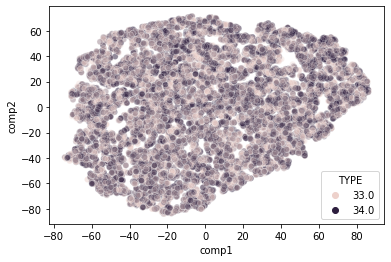

In [29]:
sns.scatterplot(
    x="comp1", y="comp2",
    hue="TYPE",
    data=master_tsne,
    legend="full",
    alpha=0.3,
)

TYPE = 33 refers to home games, 34 refers to away games

The data looks indistinguishable when plotted against the first 2 components. We will analyse each statistic now to check for significant difference.


Referee dataset doesn't need any preprocessing, so we can procees with data analysis

# Visualize the data for analysis and check significance

In [14]:
def perform_z_test(home_df, away_df):
    ztest ,pval = stests.ztest(home_df, x2=away_df, value=0,alternative='two-sided')
    print('Z statistic : ', float(ztest))
    print('p value : ', float(pval))
    if pval<0.05:
        print("Reject null hypothesis, i.e., there is significant difference between the 2 samples.")
    else:
        print("Accept null hypothesis, i.e., there is no significant difference between the 2 samples.")

In [15]:
# funnction to plot home and away stats by year
def plt_home_away_features_by_year(home_df, away_df, feature):
    home_df = home_df.groupby('YEAR')
    away_df = away_df.groupby('YEAR')
    home_store = []
    away_store = []
    
    for year, group in home_df:
        home_store.append(group[feature].mean())
    for year, group in away_df:
        away_store.append(group[feature].mean())
    X = np.arange(2002, 2021)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,0.8])
    ax.bar(X + 0.00, home_store, color = 'b', width = 0.25)
    ax.bar(X + 0.25, away_store, color = 'r', width = 0.25) 
    plt.xlabel('YEAR')
    plt.ylabel(feature)
    plt.legend(['Home', 'Away'],loc=2)

# GAMEPLAY STATS ANALYSIS

### AST/TO ANALYSIS

AST : An “assist” goes to the player who passes the ball to a teammate who then scores a basket.

TO  : A “turnover” is when a player loses possession of the ball to the opposite team. 
       Examples of turnovers include: stepping out of bounds, passing the ball out of bounds, creating an offensive foul,\
       being called for a violation, or having the ball stolen.
       
AST/TO : Assist to turnover ratio puts a player’s assists in context with their turnovers. It is often considered as 
measure of ball control/game dominance.

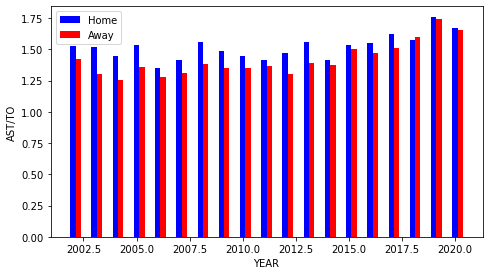

In [16]:
# plot the average AST/TO of players for home and away games
plt_home_away_features_by_year(master_home, master_away, 'AST/TO')

In [17]:
perform_z_test(master_home['AST/TO'], master_away['AST/TO'])

Z statistic :  6.225903072031957
p value :  4.787900181286169e-10
Reject null hypothesis, i.e., there is significant difference between the 2 samples.


Observation:

Every year with the exception of 2018 has higher average AST/TO per player in home games than away games.

Possible Reasons : 
1. Home team players have significantly better assist stats.
2. Away team give the ball away more and have greater turnovers.


### AVERAGE STEALS BY A PLAYER ANALYSIS

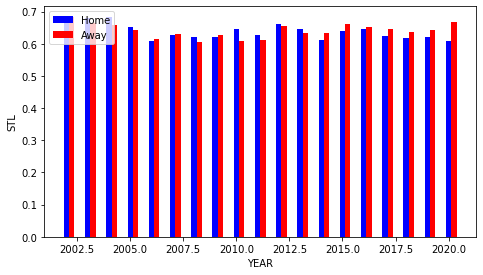

In [18]:
# plot the average steals by a player for home and away games
plt_home_away_features_by_year(master_home, master_away, 'STL')

In [19]:
perform_z_test(master_home['STL'], master_away['STL'])

Z statistic :  -0.5994633152580221
p value :  0.5488639661965138
Accept null hypothesis, i.e., there is no significant difference between the 2 samples.


### AVERAGE FOULS BY A PLAYER ANALYSIS

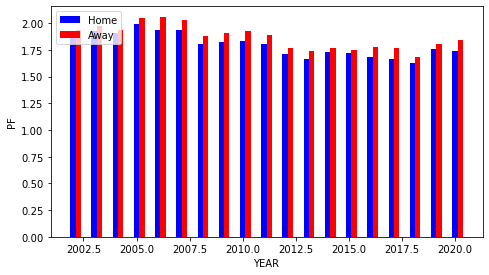

In [20]:
# plot the average fouls conceded by a player for home and away games
plt_home_away_features_by_year(master_home, master_away, 'PF')

In [21]:
perform_z_test(master_home['PF'], master_away['PF'])

Z statistic :  -5.643616891124309
p value :  1.6651438162018542e-08
Reject null hypothesis, i.e., there is significant difference between the 2 samples.


Observation : 
    
Every single season, on average the away team player concedes more fouls per game than home team players. This could have 2 possible inferences:
1. The away players are nervous/get frustrated leading to more fouls committed.
2. The referees decision is biased and the home team generally gets the favour of a decision. (We will look into this later).

### TUNROVERS BY A PLAYER ANALYSIS

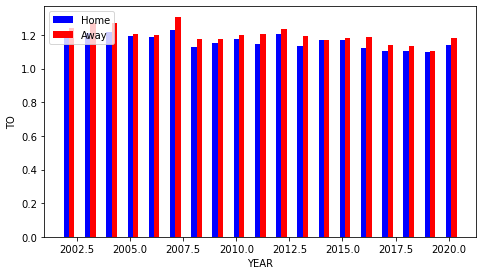

In [22]:
# As mentioned earlier, TO (Turnover) refers to the number of times the player gave away possession of the ball.
# plot the average turnover per player in home/away games.
plt_home_away_features_by_year(master_home, master_away, 'TO')

Observation :

In every year apart from 2014(same), the away team players gave away the ball more on average than home team players. 

In [23]:
perform_z_test(master_home['TO'], master_away['TO'])

Z statistic :  -2.9971631422636307
p value :  0.0027250483797951978
Reject null hypothesis, i.e., there is significant difference between the 2 samples.


Possible Reasons:

1. The home team players are significantly better at stealing the ball. (Disproven previously)
2. The away team players committed more fouls / mistakes and gave away the ball. (Proven to be significant previously)

### OFFENSIVE REBOUNDS ANALYSIS

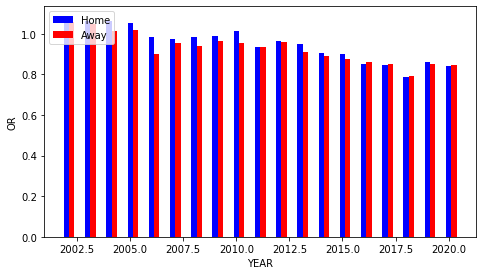

In [24]:
# Offensive rebounds awarded to a player analysis
plt_home_away_features_by_year(master_home, master_away, 'OR')

In [25]:
perform_z_test(master_home['OR'], master_away['OR'])

Z statistic :  1.643050211119988
p value :  0.10037254496864959
Accept null hypothesis, i.e., there is no significant difference between the 2 samples.


### DEFENSIVE REBOUNDS ANALYSIS

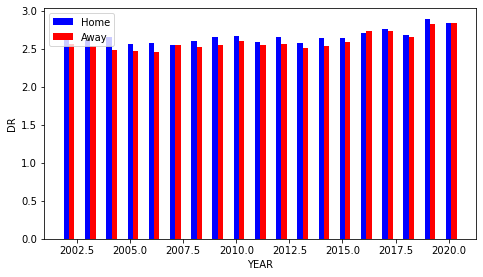

In [26]:
# Defensive rebounds awarded to a player analysis
plt_home_away_features_by_year(master_home, master_away, 'DR')

In [27]:
perform_z_test(master_home['DR'], master_away['DR'])

Z statistic :  2.4337663677626167
p value :  0.01494263645855765
Reject null hypothesis, i.e., there is significant difference between the 2 samples.


Observations : 
    
Home teams have significantly more defensive rebounds than away teams. 

Possible Reason:
Away teams are worse in shooting efficiency than home teams.(We will analyze this next).

# SHOOTING STATS ANALYSIS

### GENERAL SHOOTING EFFICIENCY ANALYSIS

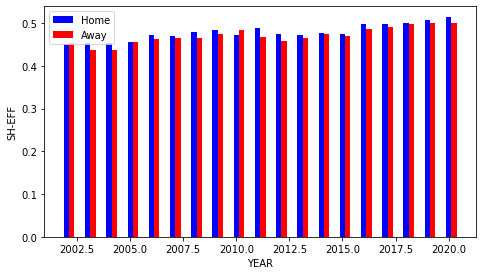

In [28]:
# plot the average shooting efficiency for players for home and away games
plt_home_away_features_by_year(shots_home, shots_away, 'SH-EFF')

Observation : 

In every year apart from 2002(away more), 2010(away more) and 2005(equal) the home team players had higher shooting efficiency than away team players on average. This could mean that away players were nervous/intimidated.

In [29]:
perform_z_test(shots_home['SH-EFF'], shots_away['SH-EFF'])

Z statistic :  4.418698338729855
p value :  9.929712941203198e-06
Reject null hypothesis, i.e., there is significant difference between the 2 samples.


So there is a significant difference between the shooting efficiencies of home and away teams.
Now this can be due to 3 factors :
    
    1. Shooting efficiency of 2 Pointers
    
    2. Shooting efficiency of 3 Pointers
    
    3. Shooting efficiency of free throws
    
So we will now have a look at each.

### 2 POINTERS ANALYSIS

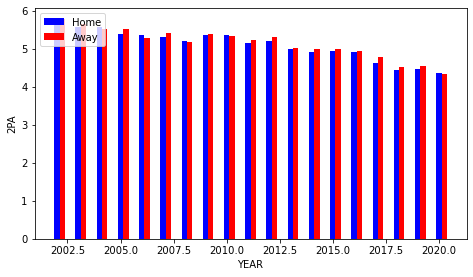

In [30]:
# plt the average number of 2 pointers attempted per game
plt_home_away_features_by_year(shots_home, shots_away, '2PA')

In [31]:
perform_z_test(shots_home['2PA'], shots_away['2PA'])

Z statistic :  -0.8526307483651704
p value :  0.39386410544680517
Accept null hypothesis, i.e., there is no significant difference between the 2 samples.


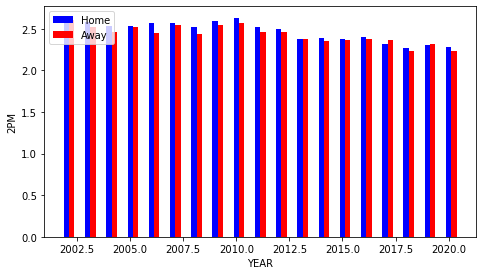

In [32]:
# plt the average number of 2 pointers successfully made per game
plt_home_away_features_by_year(shots_home, shots_away, '2PM')

In [33]:
perform_z_test(shots_home['2PM'], shots_away['2PM'])

Z statistic :  1.3953308957893766
p value :  0.16291607941058028
Accept null hypothesis, i.e., there is no significant difference between the 2 samples.


### 3 POINTERS ANALYSIS

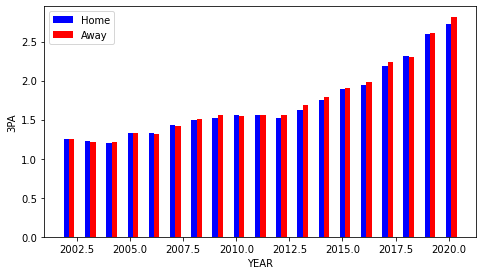

In [34]:
# plt the average number of 3 pointers attempted per game
plt_home_away_features_by_year(shots_home, shots_away, '3PA')

In [35]:
perform_z_test(shots_home['3PA'], shots_away['3PA'])

Z statistic :  -0.8209555218335292
p value :  0.4116716036714274
Accept null hypothesis, i.e., there is no significant difference between the 2 samples.


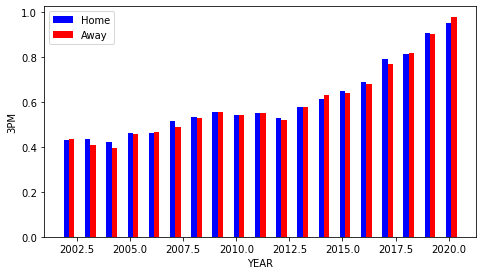

In [36]:
# plt the average number of 3 pointers successfully made per game
plt_home_away_features_by_year(shots_home, shots_away, '3PM')

In [37]:
perform_z_test(shots_home['3PM'], shots_away['3PM'])

Z statistic :  0.2485364417261448
p value :  0.8037193779594516
Accept null hypothesis, i.e., there is no significant difference between the 2 samples.


### FREE THROWS ANALYSIS

Free throws are given to a team when the opponent commits a foul. We have previously seen that Away team players commit significantly more number of fouls.
So, they get more number of free throws.


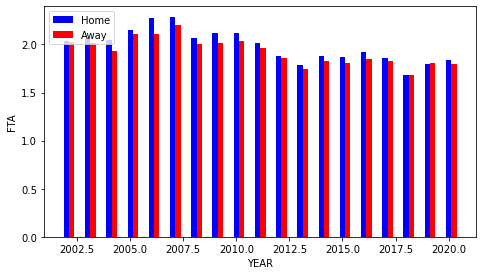

In [38]:
# plt the average number of free throws attempted per game
plt_home_away_features_by_year(shots_home, shots_away, 'FTA')

Observation: 

In every year with the exception of 2019, home teams have attempted more free throws on average than away teams. 

In [39]:
perform_z_test(shots_home['FTA'], shots_away['FTA'])

Z statistic :  2.142252588228268
p value :  0.0321731618059978
Reject null hypothesis, i.e., there is significant difference between the 2 samples.


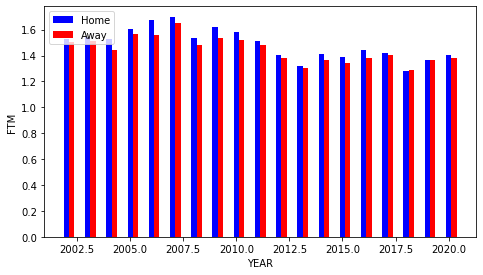

In [40]:
# plt the average number of free throws successfully made per game
plt_home_away_features_by_year(shots_home, shots_away, 'FTM')

In [41]:
perform_z_test(shots_home['FTM'], shots_away['FTM'])

Z statistic :  1.990450129038556
p value :  0.046541372476880116
Reject null hypothesis, i.e., there is significant difference between the 2 samples.


### CONCLUSION FROM SHOOTING STATS

Observation:
    
The difference in shooting efficiency of Free throws is the major reason behind differences in shooting efficiency.
Home Teams were awarded significantly more Free Throws than away teams.
Home Teams had higher successful free throws made per game than away teams.

Possible Reason:
    
We have seen earlier that away teams give away significantly more number of fouls on average than home teams.
Again this could be because referees are biased towards home teams OR away players are frustrated/nervous and commit more 
mistakes. 

# REFEREE STATS ANALYSIS

In [42]:
# Plot the average number of fouls given against home and away teams 

In [43]:
def plot_referee_stat_by_year(ref_dset, feature1, feature2):
    ref_dset = ref_dset.groupby('YEAR')
    stat1 = []
    stat2 = []
    for year, group in ref_dset:
        stat1.append(group[feature1].mean())
        stat2.append(group[feature2].mean())
    X = np.arange(2009, 2021)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,0.8])
    ax.bar(X + 0.00, stat1, color = 'b', width = 0.25)
    ax.bar(X + 0.25, stat2, color = 'r', width = 0.25) 
    plt.xlabel('YEAR')
    plt.ylabel('Fouls Against')
    plt.legend(['Home', 'Away'],loc=2)

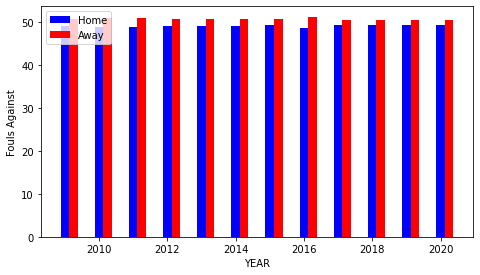

In [44]:
plot_referee_stat_by_year(ref_df, 'FAH%', 'FAR%')

In [45]:
perform_z_test(ref_df['FAH%'], ref_df['FAR%'])

Z statistic :  -16.199077354022496
p value :  5.1189334084260145e-59
Reject null hypothesis, i.e., there is significant difference between the 2 samples.


#### Conclusion:
    
We can see that there is significant difference between fouls awarded to home and away players. 
On average, a referee is more likely to give away fouls to the home team than the away team. 